In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
#creat a backup
(x_train_b, y_train_b), (x_test_b, y_test_b) = (x_train, y_train), (x_test, y_test)
#restore backup
#(x_train, y_train), (x_test, y_test) = (x_train_b, y_train_b), (x_test_b, y_test_b)

Prepare the test and training images by dividing their values by 255, storing the
result in variables x_train and x_test. The shapes of the image matrices are already
correct for input into Keras. Convert the training and test labels to categorical
variables, as for the handwritten digits in Learning-based Exercise One, storing the
result in variables y_train and y_test.

In [4]:
x_train =  x_train/255
x_test =  x_test/255
y_train = y_train.astype(str)
y_test = y_test.astype(str)

In [5]:
# Get images
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = keras.datasets.mnist.load_data()
(x_train_color, y_train_color), (x_test_color, y_test_color) = keras.datasets.cifar100.load_data()
img_color = x_train_color[3]
img_NB = x_train_raw[0]

# Create filters (2D for B&W et 3D for colored image)
horizontal_filter2D = np.array([[1,1,1],
                             [0,0,0],
                             [-1,-1,-1]])
vertical_filter2D = np.array([[-1,0,1],
                             [-1,0,1],
                             [-1,0,1]])
filters2D = np.stack((horizontal_filter2D, vertical_filter2D))

horizontal_filter3D = np.zeros((3,3,3))
horizontal_filter3D[0] = horizontal_filter2D

vertical_filter3D = np.zeros((3,3,3))
vertical_filter3D[0] = vertical_filter2D

filters3D = np.stack((horizontal_filter3D,vertical_filter3D))

In [6]:
def convo(input, input_type, filters):

    # Image pre-processing
    if input_type == 'img':
        ## Transpose colored images to the same shape as stacked filters
        if input.ndim == 4 :
            input = np.transpose(input, axes = (0,3,1,2))
        if input.ndim == 3 :
            input = np.transpose(input, axes = (2,0,1))

    #Expand input image to be in an image with 1 colour channel
    if input.ndim==2:
        input = np.expand_dims(input, axis=0)
        
    #Expand input image to be in an image stack of 1
    if input.ndim==3:
        input = np.expand_dims(input, axis=0)

    
    #Expand 2D filter to have 1 channel (3D)
    if filters.ndim==2: 
        filters = np.expand_dims(filters, axis=0)

    #Expand 3D filter to be in a filter stack of 1
    if filters.ndim==3:
        filters = np.expand_dims(filters, axis=1)
        

    num_features, input_channels, input_height, input_width = input.shape
    num_filters, filter_channels, filter_height, filter_width = filters.shape

    if input_channels!=filter_channels:
        if num_features==filter_channels:
            #in the rare time you pass multiple 2D filters this corrects the expansion accross channels and stacks
            input = np.transpose(input, axes = (1,0,2,3))
            num_features, input_channels, input_height, input_width = input.shape
        else: raise Exception("input_channels does not equal filter_channels, but these should have same dimension!")
    
    #0 padding
    pad_size = filter_height // 2
    input_padded = np.pad(input, ((0,0),(0,0),(pad_size, pad_size), (pad_size, pad_size)), mode='constant')

    #Creating sliding window
    input_regions = np.lib.stride_tricks.sliding_window_view(input_padded, window_shape =(filter_height, filter_width), axis=(2,3))
    #returning convolved answer
    convolved_layer = np.tensordot(input_regions, filters, axes=([1,4,5], [1,2,3]))
    convolved_layer = np.transpose(convolved_layer, axes = (0,3,1,2))
    return convolved_layer


In [7]:
#The following code prints either a single or multiple images with either 1 or multiple colour channels

def print_images(x):
    if x.shape[0]==x.shape[1]==1:
        plt.imshow(x[0,0],cmap='gray')  
    elif x.shape[0]==1:
        fig, ax = plt.subplots(x.shape[1], 1, figsize=(10, 4))
        for channel in range(x.shape[1]):
            ax[channel].imshow(x[0,channel,:,], cmap='gray')
    elif x.shape[1]==1:
        fig, ax = plt.subplots(x.shape[1],1, figsize=(10, 4))
        for image in range(x.shape[0]):
            ax[image].imshow(x[image,1], cmap='gray')
    else:
        fig, ax = plt.subplots(x.shape[1], x.shape[0], figsize=(20, 6))
        for image in range(len(x)):
            for channel in range(x.shape[1]):
                ax[channel, image].imshow(x[image,channel], cmap='gray')
plt.show()

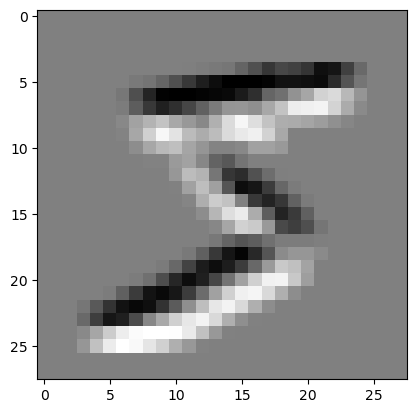

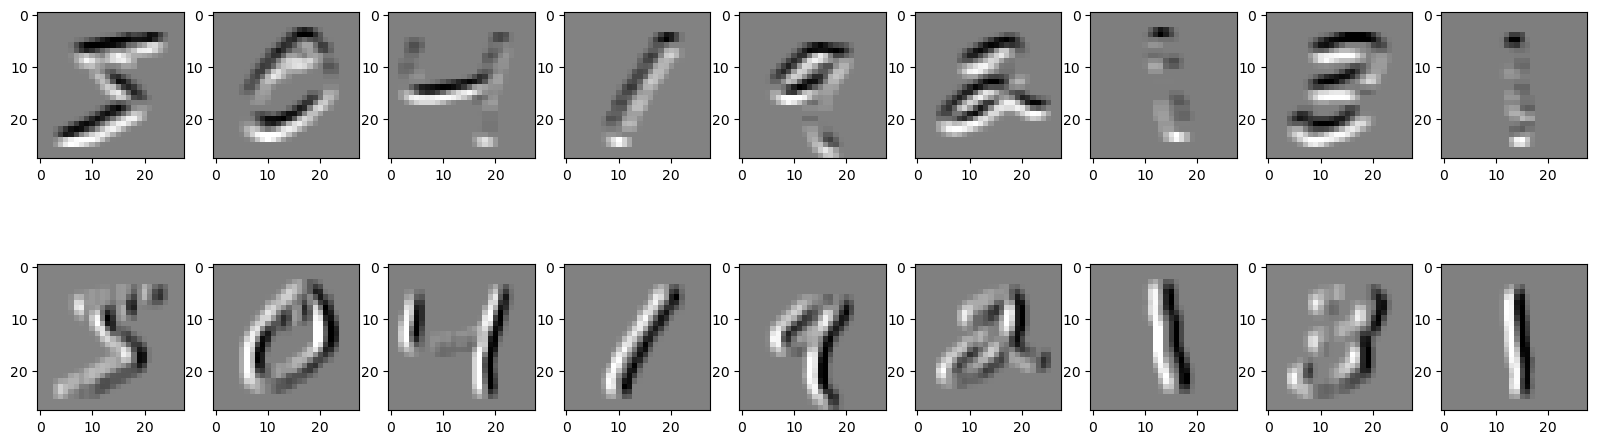

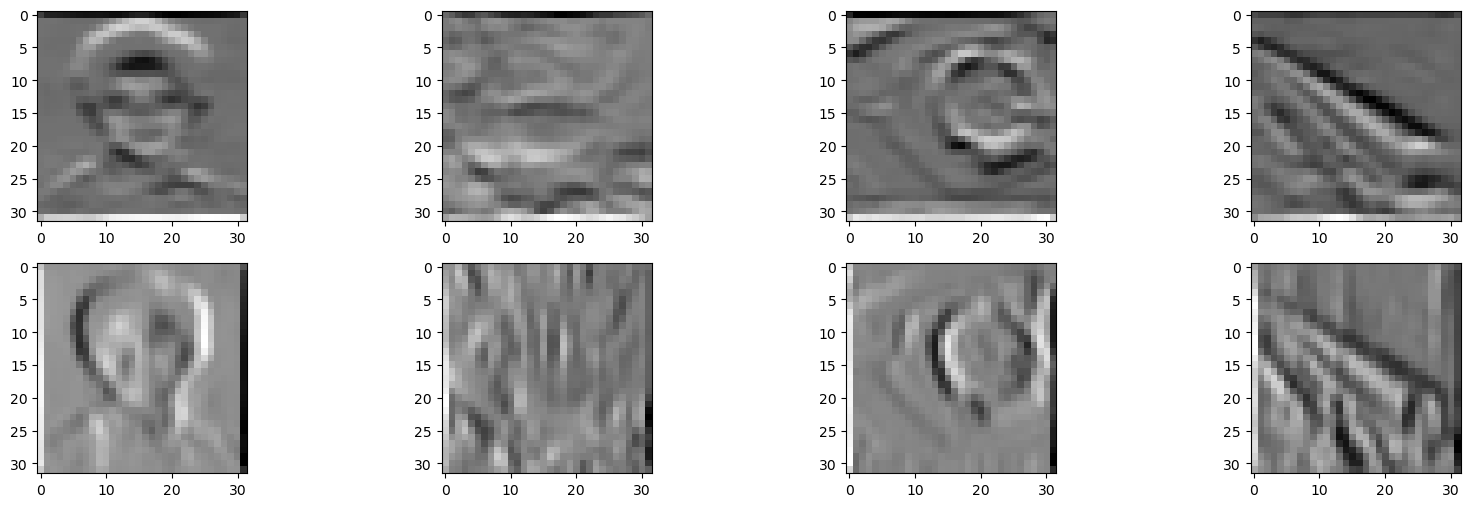

In [8]:
# Example 1 BW pic and 1 filter
x = convo(x_train_raw[0], 'not img', horizontal_filter2D)
print_images(x)

# Example 9 bw pics and two filters
x  = convo(x_train_raw[0:9], 'not img', filters2D)
print_images(x)


# Example 4 colored pics and two filters
x  = convo(x_train_color[3:7], 'img', filters3D)
print_images(x)

In [9]:
def relu(feature_map):
    #Performs rectified linear activation with low-level functions only.
    #feature_map : stack of at least two 2D or 3D feature maps
    return feature_map.clip(0)

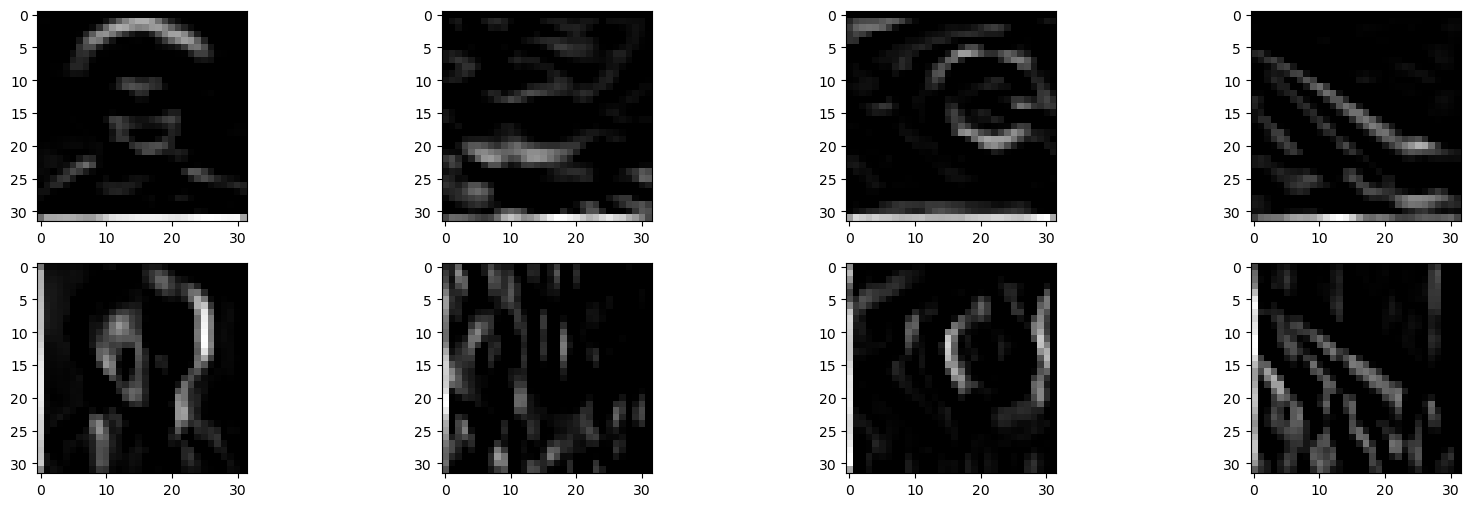

In [10]:
# Relu example
example = relu(x)
print_images(example)

In [11]:
def pool(feature_maps, pool_size):
    '''
    performs max pooling accross the feature maps
    feature_maps : stack of at least two 2D or 3D feature maps
    pool_size:tuple containing pool height & length eg (2,2) 
    '''
    n_images, n_channels, nrows, ncols = feature_maps.shape
    ph, pw = pool_size
    # pad the input array if it's not a multiple of the pool height and pool width
    pad_width =  ((0,0),(0,0),(0,-ncols%ph),(0,-ncols%pw))
    feature_maps = np.pad(feature_maps,pad_width, mode='constant')
    nrows, ncols = feature_maps.shape[-2:]
    return feature_maps.reshape(n_images, n_channels,nrows//ph, ph, ncols//pw, pw).max(axis=(3,5))

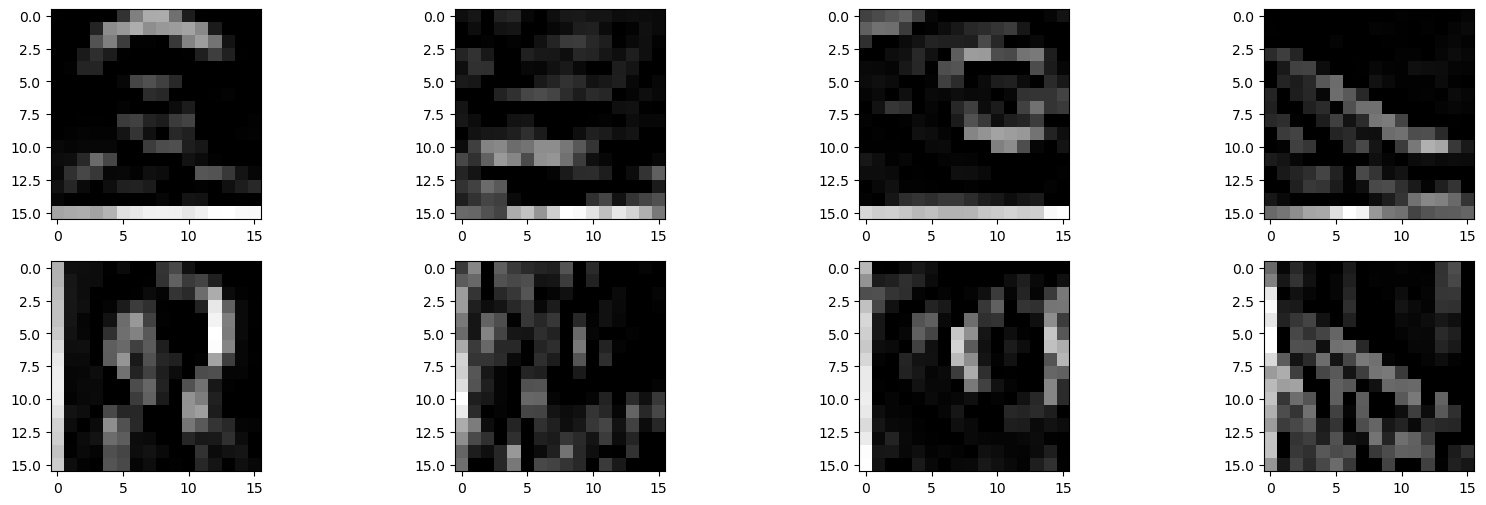

In [12]:
# pool example
example2 = pool(example, (2,2))
print_images(example2)

In [13]:
def norm(feature_maps):
    #performs normalization accross the feature maps
    #feature_maps : stack of at least two 3D feature maps
    print(feature_maps.std(), feature_maps.mean())
    return (feature_maps-feature_maps.mean())/feature_maps.std()

139.00664218634412 89.7255859375


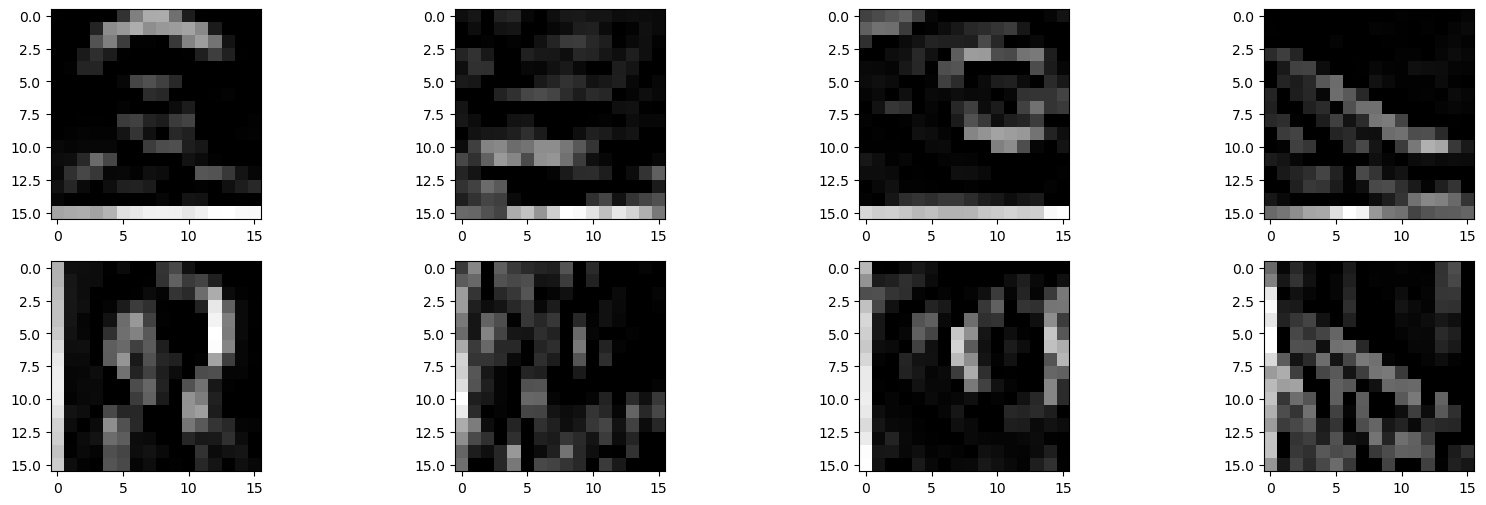

In [14]:
# normalization example
example3 = norm(example2)
print_images(example3)

In [15]:
def top_layer(feature_map, weights) :
    '''
    Get the activation of a fully connected layer after flattening the feature maps and without bias term.

    feature_map : stack of 2D feature maps
    weights : a 2D matrix of shape (flattened feature_map, number of desired nodes)
    '''
    # Flatten
    feature_map = feature_map.reshape(-1)
    # Forward
    return np.matmul(feature_map, weights)

In [16]:
# Top layer example with 5 nodes in the fully connected layer
len_weights_example = example3.shape[0]*example3.shape[1]*example3.shape[2]*example3.shape[3]
weights = np.random.randint(0, 3, size=(len_weights_example,5))
out = top_layer(example3, weights)
out

array([ 84.76994877, -38.24093624,  95.22044563,  15.4662194 ,
       -12.14022754])

In [17]:
def softmax(top_layer_out):
    '''
    top_layer_out : 1D array reflecting the fully connected layer activation
    '''
    out = np.e**top_layer_out/ np.sum(np.e**top_layer_out)
    return out 

In [18]:
#softmax example
softmax(out)

array([2.89330567e-05, 1.09256112e-58, 9.99971067e-01, 2.30763479e-35,
       2.36504552e-47])